In [0]:
from pyspark.sql.types import *
import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

#Pre-processing

In [0]:
profiles_first = spark.read.parquet('/linkedin/people')

In [0]:
profiles_first.columns

Out[3]: ['about',
 'avatar',
 'certifications',
 'city',
 'country_code',
 'current_company',
 'current_company:company_id',
 'current_company:name',
 'education',
 'educations_details',
 'experience',
 'followers',
 'following',
 'groups',
 'id',
 'languages',
 'name',
 'people_also_viewed',
 'position',
 'posts',
 'recommendations',
 'recommendations_count',
 'timestamp',
 'url',
 'volunteer_experience',
 'сourses']

In [0]:
profiles = spark.read.parquet('/linkedin/people')[['position', 'id', 'experience', 'education']].dropna(subset=['position', 'id'])

In [0]:
profiles.count()

Out[6]: 3334088

In [0]:
profiles = profiles.filter(profiles["position"] != '-')

In [0]:
profiles = profiles.filter(profiles["position"] != '--')

In [0]:
profiles = profiles.filter(profiles["position"] != '.')

In [0]:
profiles = profiles.filter(profiles["position"] != 'at')

In [0]:
profiles.count()

Out[11]: 2536258

In [0]:
from collections import Counter
import pandas as pd
from pathlib import Path
from pyspark.sql.functions import col, explode, lower, udf, collect_set, size, abs, lit, array, when
from pyspark.sql.types import IntegerType, StringType, ArrayType, StructType

In [0]:
profiles= profiles.dropna()

In [0]:
from pyspark.sql.functions import col, struct, array_contains, expr, size
profiles_ex = profiles.filter(expr("exists(experience, x -> x is not null)"))

In [0]:
profiles_ex.count()

Out[18]: 2330233

In [0]:
df_extracted = profiles_ex.withColumn("experience_description", expr("transform(experience, x -> x.description)")) \
                .withColumn("experience_duration", expr("transform(experience, x -> x.duration)"))

In [0]:
df1 = df_extracted.filter(~((size(col("experience_duration")) == 1) & col("experience_duration")[0].isNull()))
df1 = df1.filter(~((size(col("experience_description")) == 1) & col("experience_description")[0].isNull()))
df1.count()

# Display the filtered DataFrame

Out[35]: 1291164

In [0]:
df_ed_split = df1.withColumn("education_degree", expr("transform(education, x -> x.degree)")) \
                .withColumn("education_field", expr("transform(education, x -> x.field)"))\
                .withColumn("education_title", expr("transform(education, x -> x.title)"))

In [0]:
df_ed_split = df_ed_split.drop("experience", "education")

In [0]:
def contains_null(x):  
    if x is None:  
        return False  
    for i in x:  
        if i is None or i=="N/A" or i=='null':  
            return True  
    return False  
  
contains_null_udf = udf(contains_null, BooleanType())  
  
df_ed_split1 = df_ed_split.withColumn("contains_null", contains_null_udf(col("education_degree")))  
df_ed_split1 = df_ed_split1.filter(col("contains_null") == False)  
df_ed_split1 = df_ed_split1.drop("contains_null") 

In [0]:
df_ed_split2 = df_ed_split1.withColumn("contains_null", contains_null_udf(col("education_field")))  
df_ed_split2 = df_ed_split2.filter(col("contains_null") == False)  
df_ed_split2 = df_ed_split2.drop("contains_null") 

In [0]:
df_ed_split3 = df_ed_split2.withColumn("contains_null", contains_null_udf(col("education_title")))  
df_ed_split3 = df_ed_split3.filter(col("contains_null") == False)  
df_ed_split3 = df_ed_split3.drop("contains_null") 

In [0]:
df_ed_split4 = df_ed_split3.withColumn("contains_null", contains_null_udf(col("experience_description")))  
df_ed_split4 = df_ed_split4.filter(col("contains_null") == False)  
df_ed_split4 = df_ed_split4.drop("contains_null") 

In [0]:
df_ed_split5 = df_ed_split4.withColumn("contains_null", contains_null_udf(col("experience_duration")))  
df_ed_split5 = df_ed_split5.filter(col("contains_null") == False)  
df_ed_split5 = df_ed_split5.drop("contains_null") 

In [0]:
df_ed_split.count(), df_ed_split1.count(), df_ed_split2.count(), df_ed_split3.count(), df_ed_split4.count(), df_ed_split5.count()

Out[72]: (1291164, 1053494, 786563, 786333, 142961, 142480)

In [0]:
df_filtered = df_ed_split5.filter(size("education_field") == size("education_degree"))
df_filtered = df_filtered.filter(size("education_field") == size("education_title"))
df_filtered = df_filtered.filter(size("education_title") == size("education_degree"))
df_filtered.count()

Out[80]: 142480

In [0]:
# Add a new column 'experience_length' with the length of the 'experience' array
df_with_length = df_ed_split5.withColumn("experience_length", size("experience_description"))
df_with_length = df_with_length.withColumn("education_length", size("education_degree"))

In [0]:
df_with_length.limit(5).toPandas()

,position,id,experience_description,experience_duration,education_degree,education_field,education_title,experience_length,education_length
0,"Reunification Services, Divorce Coaching, Complex Relationship Counseling, Parenting Coordination, Co-Parenting Education, Adult Mental Behavioral Health,",raklcsw,"[I graduated from Jane Addams College of Social Work at the University of Illinois, Chicago (1982) with an MSW. I began as a social worker in a hospital; advanced to clinical specialty areas where I also taught populations from volunteers to pastoral care interns and internal medicine residents; advanced to supervisor of clinical social workers and volunteered at hospice and the American Cancer Society, rising to leadership positions. After developing the hospital case management department, in 1995 I opened my private practice to include consulting and teaching and quickly developed and grew a group practice of clinicians with insurance contracts and employee assistance program (EAP) companies. Administrative duties took me too far away from direct clinical work; returned to my private practice and advanced Critical Incident Stress Management (CISM) training to include specialty areas of aviation and banking industries. I am a frequently requested speaker at conferences and workshops, and have conducted basic and advanced training on a number of clinical issues and topics. Show less, Private Practice Divorce Coach Collaborative Mediation, Adult Treatment of Childhood Trauma, Clinical Social Work, College Faculty; Critical Incident Stress Management Responder, Frequently Requested Speaker. Private Practice Divorce Coach Collaborative Mediation, Adult Treatment of Childhood Trauma, Clinical Social Work, College Faculty; Critical Incident Stress Management Responder, Frequently Requested Speaker.]","[May 1999 - Present 24 years 5 months, May 1999 - Present 24 years 5 months]","[Master's Degree, Bachelor's Degree]","[Clinical/Medical Social Work, Administration, Applied Behavioral Science]","[Jane Addams College of Social Work, University of Illinois, Chicago., George Williams College, Downers Grove, Illinois.]",2,2
1,Bank Teller at Wells Fargo,thomas-jensen-5904b2276,"[Complete operational activities while minimizing risk under established policies, educate and connect customers and share the value of mobile banking options, help identify information and services to meet customer financial needs. maintain a secure cashline with high volume cash transactions. Complete operational activities while minimizing risk under established policies, educate and connect customers and share the value of mobile banking options, help identify information and services to meet customer financial needs. maintain a secure cashline with high volume cash transactions., Manage the front-end guest flow; direct and support the service team; educate team members and guests on products and services; and close the books including counting and reconciling cash drawers and daily transactions. Manage the front-end guest flow; direct and support the service team; educate team members and guests on products and services; and close the books including counting and reconciling cash drawers and daily transactions.]","[Jan 2022 - Present 1 year 9 months, Oct 2020 Mar 2022 1 year 6 months]",[],[],[],2,0
2,billing specialist,daily-saez-21aa89a9,"[office manager, billing and credentialing specialist office manager, billing and credentialing specialist]",[Feb 2018 - Present 5 years 8 months],[],[],[],1,0
3,(S.E.R.R.T) Special Education Resource Room Teacher for Prince George's County Public Schools,brandon-m-johnson-97b84231,"[Under the direction of the Assistant Supervisor for Instructional Supports, Assessment and Accountability for the Department of Special Education, I monitor, train, and provide technical assistance to schools to successfully implement instructional supports and intervention programs for students with disabilities. I coach educators on the deli

In [0]:
# path_to_dir = "/dbfs/Users/almoogben"
# Path.mkdir(Path(path_to_dir), exist_ok=True)

# df_with_length.write.format("parquet").save(f"/df_without_null.parquet")

In [0]:
df_processed = spark.read.parquet("/df_without_null.parquet")

In [0]:
df_processed.select('experience_duration').distinct().show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|experience_duration                                                                                                                                                                                                                                                                                                                                                                    |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [0]:
from pyspark.sql.functions import udf, explode, sum, col
from pyspark.sql.types import FloatType  
import re  
  
# Define the UDF  
def convert_to_years(duration):  
    years = 0  
    months = 0  
  
    # Use regex to find any number of years in the string  
    years_match = re.search(r'(\d+) year', duration)  
    if years_match:  
        years = int(years_match.group(1))  
  
    # Use regex to find any number of months in the string  
    months_match = re.search(r'(\d+) month', duration)  
    if months_match:  
        months = int(months_match.group(1))  
  
    # Convert months to years and add to the year total  
    total_years = years + months/12  
    return total_years  
  
# Convert Python function to PySpark UDF and specify return type  
convert_to_years_udf = udf(convert_to_years, FloatType())  
  
# Flatten the array column  
df = df_processed.withColumn('experience_duration', explode(df_processed['experience_duration']))  
  
# Apply UDF to the column  
df = df.withColumn('experience_duration_years', convert_to_years_udf(df['experience_duration'])) 

# Sum all the years for each id  
df = df.groupBy("id").agg(sum("experience_duration_years").alias("total_experience_years"))  

# Join the original dataframe with the aggregated dataframe  
df_processed_final = df_processed.join(df, on='id', how='left').drop('experience_duration', 'experience_length')  

# Convert 'total_experience_years' to integer  
df_processed_final = df_processed_final.withColumn('total_experience_years', col('total_experience_years').cast('integer'))  


In [0]:
df_processed_final.limit(5).toPandas()

,id,position,experience_description,education_degree,education_field,education_title,education_length,total_experience_years
0,joseph-berard-14475461,Program Aide at Families in Transition,[• Worked with women and single families who h...,"[Bachelor's degree, High School Diploma, high ...","[Human Services, General, Regular/General High...","[Granite State College, Shortridge Academy, do...",3,6
1,kevin-white-ab041616,Sales Specialist at Magnolia Realty,"[Sales Specialist in Rural Properties, First T...",[],[],[],0,20
2,fatima-mubashir-31558631,Business Operations Associate at Dohmen Life S...,"[• Manage monthly invoicing, accounts receivab...",[Bachelor's Degree],[Accounting],[California State University - East Bay],1,22
3,joseph-badolato-do-03778574,Medical Director at Vera Whole Health,"[At Vera Whole Health, we contract with compan...","[D.O.-Doctor of Osteopathy, Bachelor of Arts (...","[Family Medicine Residency Program, General St...",[Des Moines University-Osteopathic Medical Cen...,2,12
4,bobmecham,CAD Applications Manager at EnvisionCAD,[As the CADD Applications Manager I have train...,[Associate Degree],[Civil Engineering Technology],[Madison Area Technical College],1,31


In [0]:
df_processed.count(), df_processed_final.count(), df_processed_final.dropna().count()

Out[39]: (142480, 142480, 142480)

In [0]:
pd_df = df_processed_final.toPandas()

#Extract popular positions from original dataset


In [0]:

profiles_l = profiles.withColumn("position_lower", lower(col("position")))
positions_list = profiles_l.select("position_lower").rdd.flatMap(lambda x: x).collect()
print(type(positions_list))
print(f"number of positions: {len(positions_list):,}")

def extract_position_before_word_at(x):
    if " at " in x:
        return x[:x.index(" at ")]
    else:
        return x
    
positions_list = list(map(extract_position_before_word_at, positions_list))

count = Counter(positions_list)

positions_counted = list(count.items())
positions_counted = sorted(positions_counted, key=lambda x: x[1], reverse=True)

above_300 = [x for x in positions_counted if x[1] >= 300]
print(f">>> there are {len(above_300):,} positions which occur above 300 times")

positions_above_300_df = pd.DataFrame(above_300, columns=["position", "count_in_data"]) 


<class 'list'>
number of positions: 2,536,258
>>> there are 657 positions which occur above 300 times


In [0]:
path_to_dir = "/dbfs/Users/almoogben"
Path.mkdir(Path(path_to_dir), exist_ok=True)

positions_above_300_df.to_csv(f"{path_to_dir}/positions_above_300.csv", index=False)

In [0]:
popular_positions = spark.read.csv("/Users/almoogben/positions_above_300.csv", header=True, inferSchema=True)

#Analysis


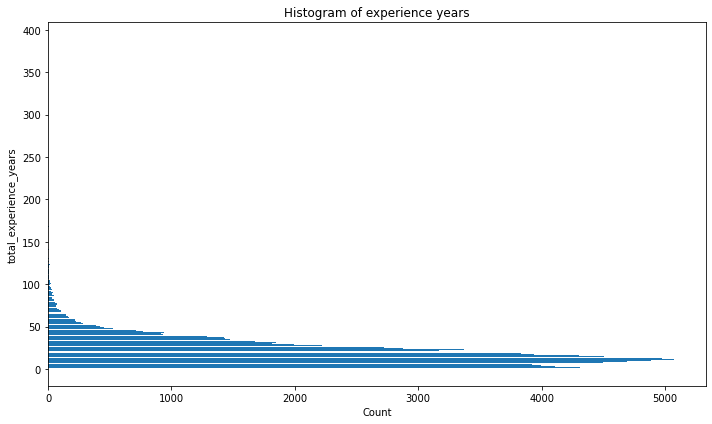

In [0]:
import matplotlib.pyplot as plt

experience_counts = df_processed_final.groupBy("total_experience_years").count().orderBy("count", ascending=False).toPandas()

plt.figure(figsize=(10, 6))
plt.barh(experience_counts["total_experience_years"], experience_counts["count"])
plt.xlabel("Count")
plt.ylabel("total_experience_years")
plt.title("Histogram of experience years")
plt.tight_layout()
plt.show()

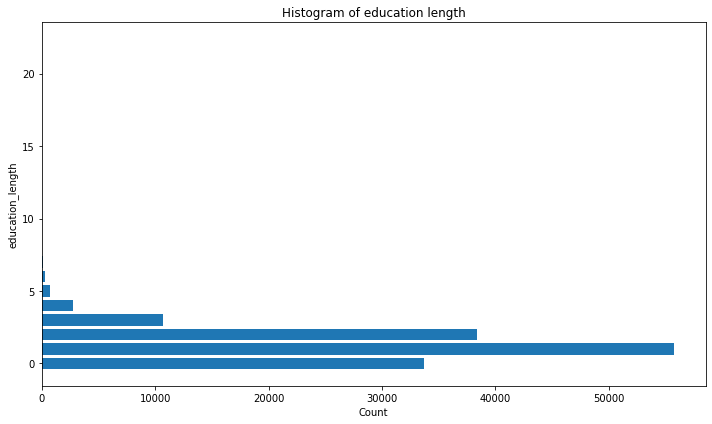

In [0]:
position_counts = df_processed_final.groupBy("education_length").count().orderBy("count", ascending=False).toPandas()

plt.figure(figsize=(10, 6))
plt.barh(position_counts["education_length"], position_counts["count"])
plt.xlabel("Count")
plt.ylabel("education_length")
plt.title("Histogram of education length")
plt.tight_layout()
plt.show()

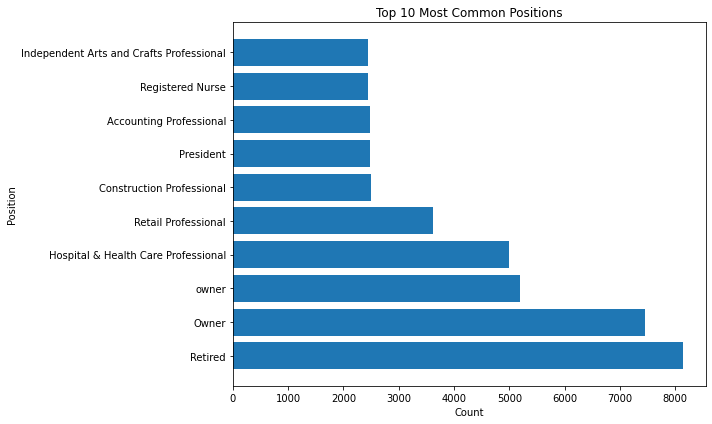

In [0]:
import matplotlib.pyplot as plt

position_counts = profiles.groupBy("position").count().orderBy("count", ascending=False)

position_counts_df = position_counts.toPandas()
top_positions = position_counts_df.head(10)

plt.figure(figsize=(10, 6))
plt.barh(top_positions["position"], top_positions["count"])
plt.xlabel("Count")
plt.ylabel("Position")
plt.title("Top 10 Most Common Positions")
plt.tight_layout()
plt.show()


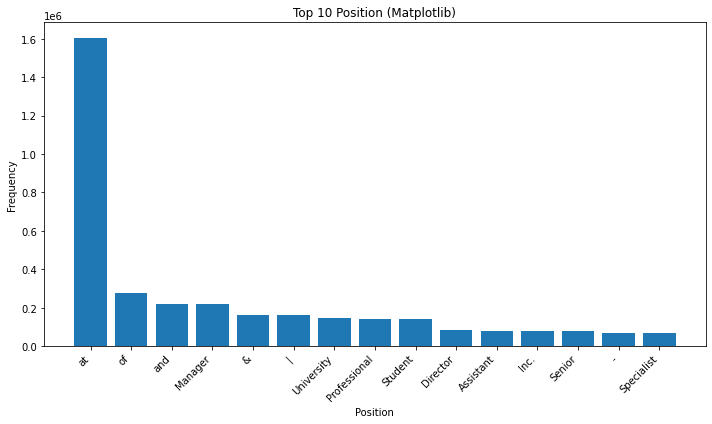

In [0]:
from collections import Counter
import matplotlib.pyplot as plt

all_positions = " ".join(profiles.select("position").rdd.flatMap(lambda x: x).collect())
positions_tokens = all_positions.split()
position_counts = Counter(positions_tokens)
top_positions = dict(sorted(position_counts.items(), key=lambda item: item[1], reverse=True)[:15])

plt.figure(figsize=(10, 6))
plt.bar(top_positions.keys(), top_positions.values())
plt.xlabel("Position")
plt.ylabel("Frequency")
plt.title("Top 10 Position (Matplotlib)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [0]:
id_unique = profiles.select("id").distinct().count() == profiles.count()
print(f"Check if he ID column is unique: {id_unique}")

Check if he ID column is unique: True


#Embedding to popular positions

In [0]:
popular_positions = spark.createDataFrame(positions_above_300_df)

In [0]:
import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.ml import Pipeline

documentAssembler = DocumentAssembler() \
    .setInputCol("position") \
    .setOutputCol("document")
tokenizer = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token")
embeddings = BertEmbeddings.pretrained("small_bert_L2_128", "en") \
    .setInputCols(["token", "document"]) \
    .setOutputCol("bert_embeddings")
embeddingsFinisher = EmbeddingsFinisher() \
    .setInputCols(["bert_embeddings"]) \
    .setOutputCols("position_bert") \
    .setOutputAsVector(True)
pipeline = Pipeline().setStages([
    documentAssembler,
    tokenizer,
    embeddings,
    embeddingsFinisher
])

popular_positions_emb = pipeline.fit(popular_positions).transform(popular_positions)

small_bert_L2_128 download started this may take some time.
Approximate size to download 16.1 MB
[OK!]


In [0]:
from pyspark.ml.feature import Word2Vec
from pyspark.ml.feature import Tokenizer

tokenizer = Tokenizer(inputCol='position', outputCol='position_tokens')
profiles_tokenized = tokenizer.transform(popular_positions_emb)

# Train word2vec model
word2Vec = Word2Vec(vectorSize=50, minCount=10, inputCol='position_tokens', outputCol='position_w2v')
model = word2Vec.fit(profiles_tokenized)

# Generate position embeddings
popular_positions_emb = model.transform(profiles_tokenized)

In [0]:
popular_positions_emb = popular_positions_emb.drop('document', 'token', 'bert_embeddings', 'position_tokens')

In [0]:
from pyspark.sql.functions import col

popular_positions_emb = popular_positions_emb.withColumn('position_bert', col('position_bert')[0])

#Embedding to the profiles data positions.

In [0]:
def extract_position_before_word_at(x):
    if " at " in x:
        return x[:x.index(" at ")]
    else:
        return x

In [0]:
from pyspark.sql import functions as F
from pyspark.sql.functions import col, explode, lower, udf, collect_set, size, abs, lit, array, when
df_processed_final = df_processed_final.withColumn("position", F.udf(extract_position_before_word_at)(F.lower(F.col('position'))))

In [0]:
from pyspark.ml.feature import Word2Vec
from pyspark.ml.feature import Tokenizer

tokenizer = Tokenizer(inputCol='position', outputCol='position_tokens')
profiles_tokenized = Tokenizer(inputCol='position', outputCol='position_tokens')
profiles_tokenized = tokenizer.transform(df_processed_final)

# Train word2vec model
word2Vec = Word2Vec(vectorSize=50, minCount=10, inputCol='position_tokens', outputCol='position_w2v')
model = word2Vec.fit(profiles_tokenized)

# Generate position embeddings
profiles_emb = model.transform(profiles_tokenized)

In [0]:
import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.ml import Pipeline

documentAssembler = DocumentAssembler() \
    .setInputCol("position") \
    .setOutputCol("document")
tokenizer = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token")
embeddings = BertEmbeddings.pretrained("small_bert_L2_128", "en") \
    .setInputCols(["token", "document"]) \
    .setOutputCol("bert_embeddings")
embeddingsFinisher = EmbeddingsFinisher() \
    .setInputCols(["bert_embeddings"]) \
    .setOutputCols("position_bert") \
    .setOutputAsVector(True)
pipeline = Pipeline().setStages([
    documentAssembler,
    tokenizer,
    embeddings,
    embeddingsFinisher
])

profiles_emb = pipeline.fit(profiles_emb).transform(profiles_emb)

small_bert_L2_128 download started this may take some time.
Approximate size to download 16.1 MB
[OK!]


In [0]:
profiles_emb = profiles_emb.drop('document', 'token', 'bert_embeddings', 'position_tokens')

In [0]:
profiles_emb = profiles_emb.withColumn('position_bert', col('position_bert')[0])

In [0]:
profiles_emb.count(), popular_positions_emb.count(), profiles_emb.dropna().count(), popular_positions_emb.dropna().count()

Out[70]: (142480, 629, 142480, 629)

In [0]:
df_processed.count()

Out[71]: 142480

In [0]:
from pathlib import Path
path_to_dir = "/dbfs/Users/almoogben"
Path.mkdir(Path(path_to_dir), exist_ok=True)

profiles_emb.write.format("parquet").save(f"/profiles_emb2.parquet")

In [0]:
popular_positions_emb.write.format("parquet").save(f"/popular_positions_emb.parquet")

#Classification with 1-NN

In [0]:
popular_positions_emb = spark.read.parquet("/popular_positions_emb.parquet")
profiles_emb = spark.read.parquet("/profiles_emb2.parquet")

In [0]:
import pyspark.sql.functions as F
import pyspark.sql.types as T

to_array = F.udf(lambda v: v.toArray().tolist(), T.ArrayType(T.FloatType()))
popular_positions_emb = popular_positions_emb.withColumn('position_w2v', to_array('position_w2v'))
popular_positions_emb = popular_positions_emb.withColumn('position_bert', to_array('position_bert'))

profiles_emb = profiles_emb.withColumn('position_w2v', to_array('position_w2v'))
profiles_emb = profiles_emb.withColumn('position_bert', to_array('position_bert'))


In [0]:
from pyspark.sql.functions import col
values_to_exclude = ['student', 'senior', 'junior', 'specialist', '--', 'at', 'principal', 'partner', '.', 'none', 'engineer', 'associate', 'null', 'intern', 'assistant', '-', 'boss', 'tech', 'self', 'na', 'member', 'employee', 'it', 'worker', 'realtor¬Æ', 'education', 'faculty', 'advisor', 'professional', 'professional', 'manager', 'senior manager', 'graduate student', 'director', 'assistant director', 'senior engineer']  # List of values to exclude

# Drop rows where the value in 'column_name' is in the list 'values_to_exclude'
popular_positions_emb = popular_positions_emb.filter(~col('position').isin(values_to_exclude))

In [0]:
profiles_emb_pd = profiles_emb.select('id', 'position', 'position_w2v', 'position_bert').toPandas()
popular_positions_emb_pd = popular_positions_emb.toPandas()

word2vec knn

In [0]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier

# Prepare the training data
X_train = np.stack(popular_positions_emb_pd['position_w2v'].apply(lambda x: np.asarray(x, dtype=float)).values)
y_train = popular_positions_emb_pd['position'].values

# Prepare the test data
X_test = np.stack(profiles_emb_pd['position_w2v'].apply(lambda x: np.asarray(x, dtype=float)).values)

# Instantiate and fit the KNN model on the training data
knn = KNeighborsClassifier(n_neighbors=1)  # Specify the number of neighbors (k=1 in this case)
knn.fit(X_train, y_train)

# Predict the labels for the test data based on the nearest neighbors from the training data
_, indices = knn.kneighbors(X_test, n_neighbors=1)  # Find the nearest neighbor (k=1)
nearest_labels = popular_positions_emb_pd.iloc[indices.flatten()]['position'].values

# Combine the original test data with the predicted labels
predicted_profiles_w2v = pd.concat([profiles_emb_pd, pd.DataFrame(nearest_labels, columns=['Predicted_Label'])], axis=1)

In [0]:
predicted_profiles_w2v[['position', 'Predicted_Label']].head(20)

,position,Predicted_Label
0,interventional radiology tech,service manager
1,system administrator,it specialist
2,structural engineer,it specialist
3,certified project manager,independent consultant
4,"account executive, field sales north east, pub...",senior software engineer
5,the counterfeit millionaire... a true crime ad...,retail professional
6,eku student and developing accountant,executive director
7,excellent,retail professional
8,student,sales director
9,corporate sales trainer with extensive leaders...,executive office professional


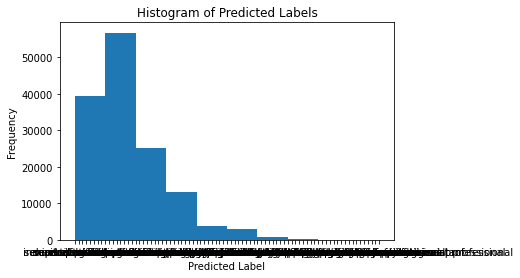

In [0]:
import matplotlib.pyplot as plt

# Plot histogram of predicted labels
plt.hist(predicted_profiles_w2v['Predicted_Label'])
plt.xlabel('Predicted Label')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted Labels')
plt.show()

bert knn

In [0]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier

# Prepare the training data
X_train = np.stack(popular_positions_emb_pd['position_bert'].apply(lambda x: np.asarray(x, dtype=float)).values)
y_train = popular_positions_emb_pd['position'].values

# Prepare the test data
X_test = np.stack(profiles_emb_pd['position_bert'].apply(lambda x: np.asarray(x, dtype=float)).values)

# Instantiate and fit the KNN model on the training data
knn = KNeighborsClassifier(n_neighbors=1)  # Specify the number of neighbors (k=1 in this case)
knn.fit(X_train, y_train)

# Predict the labels for the test data based on the nearest neighbors from the training data
_, indices = knn.kneighbors(X_test, n_neighbors=1)  # Find the nearest neighbor (k=1)
nearest_labels = popular_positions_emb_pd.iloc[indices.flatten()]['position'].values

# Combine the original test data with the predicted labels
predicted_profiles_bert = pd.concat([profiles_emb_pd, pd.DataFrame(nearest_labels, columns=['Predicted_Label'])], axis=1)

In [0]:
predicted_profiles_bert[['position', 'Predicted_Label']].head(20)

,position,Predicted_Label
0,interventional radiology tech,environmental services professional
1,system administrator,system administrator
2,structural engineer,mechanical engineer
3,certified project manager,project engineer
4,"account executive, field sales north east, pub...",account executive
5,the counterfeit millionaire... a true crime ad...,warehouse worker
6,eku student and developing accountant,marketing student
7,excellent,accounting
8,student,student-athlete
9,corporate sales trainer with extensive leaders...,territory sales manager


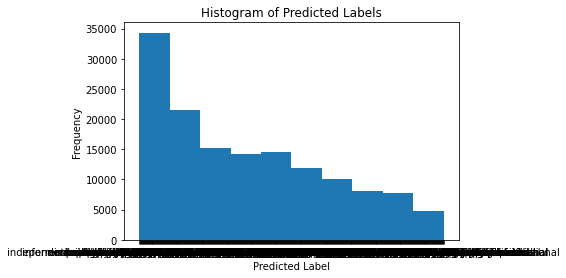

In [0]:
import matplotlib.pyplot as plt

# Plot histogram of predicted labels
plt.hist(predicted_profiles_bert['Predicted_Label'])
plt.xlabel('Predicted Label')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted Labels')
plt.show()

#### As we can see Bert is less biased than Word2Vec, So we will choose Bert embedding

In [0]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

# # Assuming 'predicted_profiles_bert' is a Pandas DataFrame
# predicted_profiles_bert_spark = spark.createDataFrame(predicted_profiles_bert)

# predicted_profiles_bert_spark.write.format("parquet").save("/predicted_profiles_bert.parquet")

In [0]:
predicted_profiles_bert = spark.read.parquet("/predicted_profiles_bert.parquet")

In [0]:
df1 = profiles_emb.drop('position_w2v', 'position_bert')
df2 = predicted_profiles_bert.drop('position_w2v', 'position_bert', 'position').withColumnRenamed("id", "id1")


In [0]:
profiles_features = df1.join(df2, df1.id == df2.id1, "inner").drop("id1")

In [0]:
from pyspark.sql.functions import count
import matplotlib.pyplot as plt
import pandas as pd
grouped_df = profiles_features.groupBy("Predicted_Label").agg(count("*").alias("count"))
# grouped_df = grouped_df.filter(grouped_df["count"] < 100)
# print(grouped_df.count())
# pandas_df = grouped_df.toPandas()


In [0]:
values_to_exclude = ['student', 'senior', 'junior', 'specialist', '--', 'at', 'principal', 'partner', '.', 'none', 'engineer', 'associate', 'null', 'intern', 'assistant', '-', 'boss', 'tech', 'self', 'na', 'member', 'employee', 'it', 'worker', 'realtor¬Æ', 'education', 'faculty', 'advisor', 'professional', 'professional', 'manager', 'senior manager', 'graduate student', 'director', 'assistant director', 'senior engineer', 'paraprofessional', 'retired', 'owner/manager', 'owner', 'president', 'consultant', 'founder', 'business owner', 'student-athlete', 'president & ceo', 'ceo', 'president and ceo', 'vice president', 'co-owner', 'small business owner', 'director', 'founder & ceo', 'coach']  # List of values to exclude

# Drop rows where the value in 'column_name' is in the list 'values_to_exclude'
popular_positions_emb = popular_positions_emb.filter(~col('position').isin(values_to_exclude))
profiles_features = profiles_features.filter(~col('Predicted_Label').isin(values_to_exclude)).drop('position')

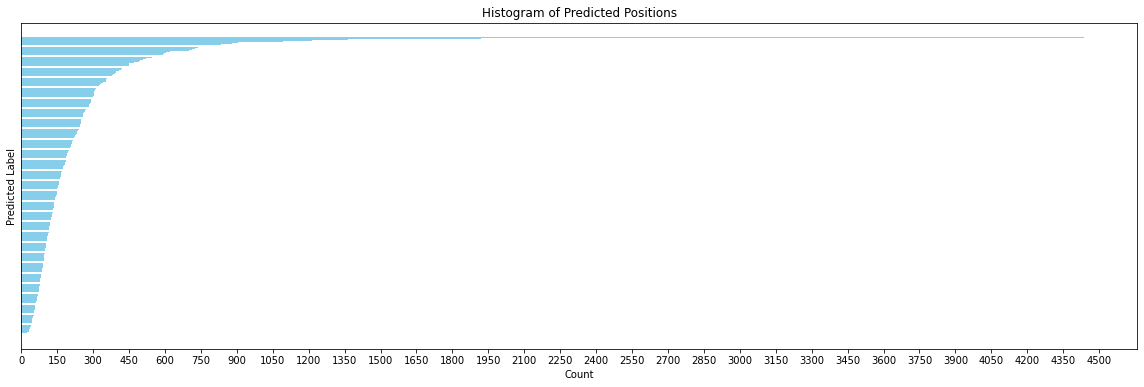

In [0]:
# Convert the PySpark DataFrame to a Pandas DataFrame for plotting
pandas_df = grouped_df.orderBy(col("count").desc()).toPandas()

# Plotting the bar chart
plt.figure(figsize=(20, 6))
plt.barh(pandas_df["Predicted_Label"], pandas_df["count"], color='skyblue')
plt.ylabel('Predicted Label')
plt.xlabel('Count')
plt.title('Histogram of Predicted Positions')
plt.gca().invert_yaxis()  # Display the top label at the top
plt.yticks([])
plt.xticks(ticks=range(0, 4501, 150))
plt.show()

In [0]:
predicted_profiles_bert.count(), popular_positions_emb.count(), popular_positions_emb_pd.count()

Out[28]: (142480,
 612,
 position         629
 count_in_data    629
 position_bert    629
 position_w2v     629
 dtype: int64)

In [0]:
# profiles_features.write.format("parquet").save(f"/profiles_features.parquet")

In [0]:
# popular_positions_emb.drop('position_w2v').write.format("parquet").save(f"/popular_positions.parquet")

## Generate salary by scrapped position salary dataset

In [0]:
popular_positions_emb = spark.read.parquet("/popular_positions.parquet")

In [0]:
profiles_features = spark.read.parquet("/profiles_features.parquet")

In [0]:
salary_positions = spark.read.table("salary_positions")

In [0]:
from pyspark.sql.functions import regexp_replace, col

# Replace commas with empty strings and cast the columns to float
cols = salary_positions.columns[1:]  # Assuming the numeric columns start from the third column
for col_name in cols:
    salary_positions = salary_positions.withColumn(col_name, regexp_replace(col(col_name), ',', '').cast('float'))

salary_positions.show()

+--------------------+-------+--------+--------+
|            position|    Low| Average|    High|
+--------------------+-------+--------+--------+
|               owner|24286.0| 59644.0|146481.0|
|             teacher|   9.14|   19.18|   40.25|
|           president|74544.0|136888.0|251374.0|
|             manager|41103.0| 76641.0|142906.0|
|    registered nurse|  28.99|    43.7|   65.87|
|      office manager|  15.33|   22.08|   31.79|
|     project manager|56904.0| 88410.0|137359.0|
|administrative as...|  13.79|   19.14|   26.56|
|                 ceo|74259.0|145470.0|284969.0|
|             realtor|49476.0| 96720.0|189074.0|
|                  rn|  28.99|    43.7|   65.87|
|               sales|37788.0| 87544.0|202814.0|
|     general manager|35651.0| 61407.0|105770.0|
|            attorney|59467.0|104290.0|182900.0|
|      business owner|   8.67|   18.18|   38.14|
|            director|58400.0|106786.0|195262.0|
|   software engineer|75514.0|120112.0|191050.0|
|      vice presiden

In [0]:
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType

# Define the UDF to accept individual column values
def generate_salary_udf(low, average):
    return average / (average - low)

# Register the UDF
generate_salary = udf(generate_salary_udf, FloatType())

# Apply the UDF to the 'salary_positions' DataFrame
salary_positions = salary_positions.withColumn('alpha param', generate_salary('Low', 'Average'))

In [0]:
from pyspark.sql.functions import col, lit
import numpy as np

# Define a UDF to generate sample values from Pareto distribution
def generate_pareto_sample(alpha, high):
    sampled_value = np.random.pareto(alpha)  # Generate a sample value from Pareto distribution
    return min(sampled_value, high)  # Limit the sampled value to be smaller than 'High'

# Register the UDF
generate_pareto_sample_udf = udf(generate_pareto_sample)

# Apply the UDF to create a new column 'pareto_sample'
salary_positions = salary_positions.withColumn('pareto_sample', generate_pareto_sample_udf(col('alpha param'), col('High')))
salary_positions.show()


+--------------------+-------+--------+--------+-----------+--------------------+
|            position|    Low| Average|    High|alpha param|       pareto_sample|
+--------------------+-------+--------+--------+-----------+--------------------+
|               owner|24286.0| 59644.0|146481.0|  1.6868601| 0.22524173626343402|
|             teacher|   9.14|   19.18|   40.25|  1.9103585|0.005281236425053848|
|           president|74544.0|136888.0|251374.0|  2.1956885|   0.211931737198487|
|             manager|41103.0| 76641.0|142906.0|  2.1565928|  0.7165429315346066|
|    registered nurse|  28.99|    43.7|   65.87|   2.970768| 0.46762529867248737|
|      office manager|  15.33|   22.08|   31.79|   3.271111| 0.22847315767658727|
|     project manager|56904.0| 88410.0|137359.0|   2.806132| 0.01639676321399719|
|administrative as...|  13.79|   19.14|   26.56|  3.5775704| 0.22171992834057552|
|                 ceo|74259.0|145470.0|284969.0|  2.0428023| 0.24383282469915035|
|             re

In [0]:
# Find the maximum value of the 'pareto_sample' column
max_value = salary_positions.selectExpr("max(pareto_sample) as max_value").collect()[0].max_value

# Find the minimum value of the 'pareto_sample' column
min_value = salary_positions.selectExpr("min(pareto_sample) as min_value").collect()[0].min_value

# Find the average value of the 'pareto_sample' column
avg_value = salary_positions.selectExpr("avg(pareto_sample) as avg_value").collect()[0].avg_value

# Print the max, min, and avg values of the 'pareto_sample' column
print("Max Value:", max_value)
print("Min Value:", min_value)
print("Avg Value:", avg_value)

Max Value: 9.097578003371964E-4
Min Value: 0.0011571227848343746
Avg Value: 0.6632599910884118


As we can see the pareto distibution alpha estimator is not good enough and sample value out of the range values.
So we tried a triangular distribution that is recommended for salary distribution and can be estimated with our data.

In [0]:
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType
import numpy as np

# Define the UDF to accept individual column values
def generate_tri_udf(low, average, high):
    return np.random.triangular(low, average, high, size=None)

# Register the UDF
generate_salary = udf(generate_tri_udf, FloatType())

# Apply the UDF to the 'salary_positions' DataFrame
salary_positions = salary_positions.withColumn('tri sample', generate_salary('Low', 'Average', 'High')).select('position', 'Low', 'Average', 'High', 'tri sample')
salary_positions.show()

+--------------------+-------+--------+--------+----------+
|            position|    Low| Average|    High|tri sample|
+--------------------+-------+--------+--------+----------+
|               owner|24286.0| 59644.0|146481.0| 59690.895|
|             teacher|   9.14|   19.18|   40.25| 10.908392|
|           president|74544.0|136888.0|251374.0| 136152.58|
|             manager|41103.0| 76641.0|142906.0| 97039.555|
|    registered nurse|  28.99|    43.7|   65.87| 49.696995|
|      office manager|  15.33|   22.08|   31.79| 22.760536|
|     project manager|56904.0| 88410.0|137359.0| 67538.125|
|administrative as...|  13.79|   19.14|   26.56| 19.756634|
|                 ceo|74259.0|145470.0|284969.0| 147774.06|
|             realtor|49476.0| 96720.0|189074.0| 164914.61|
|                  rn|  28.99|    43.7|   65.87|  39.03307|
|               sales|37788.0| 87544.0|202814.0|101040.984|
|     general manager|35651.0| 61407.0|105770.0| 48362.312|
|            attorney|59467.0|104290.0|1

In [0]:
# Join the 'salary_positions' and 'profiles_features' DataFrames
joined_df = profiles_features.join(salary_positions, salary_positions['position'] == profiles_features['Predicted_Label'])


In [0]:
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType
import numpy as np

# Define the UDF to accept individual column values
def generate_tri_sample_udf(low, average, high):
    return np.random.triangular(low, average, high, size=None)

# Register the UDF
generate_tri_salary = udf(generate_tri_sample_udf, FloatType())

joined_df = joined_df.withColumn('tri sample', generate_tri_salary('Low', 'Average', 'High'))


increase the tri sample by total_experience_years and education_length

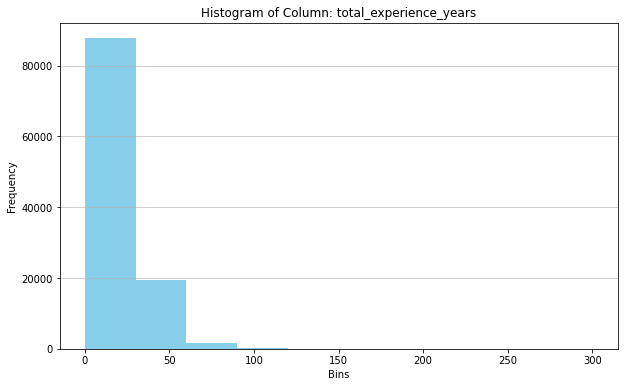

In [0]:
import matplotlib.pyplot as plt
histogram_data = joined_df.select('total_experience_years').rdd.flatMap(lambda x: x).histogram(10)

# Prepare data for plotting
bins = histogram_data[0]
frequency = histogram_data[1]

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.bar(bins[:-1], frequency, width=(bins[1]-bins[0]), align='edge', color='skyblue')
plt.xlabel('Bins')
plt.ylabel('Frequency')
plt.title('Histogram of Column: total_experience_years')
plt.grid(axis='y', alpha=0.75)
plt.show()

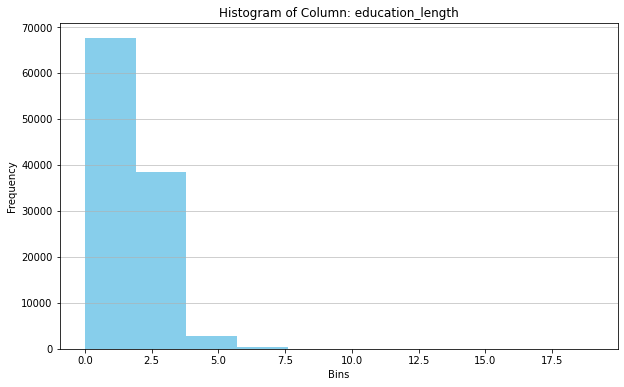

In [0]:
import matplotlib.pyplot as plt
histogram_data = joined_df.select('education_length').rdd.flatMap(lambda x: x).histogram(10)

# Prepare data for plotting
bins = histogram_data[0]
frequency = histogram_data[1]

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.bar(bins[:-1], frequency, width=(bins[1]-bins[0]), align='edge', color='skyblue')
plt.xlabel('Bins')
plt.ylabel('Frequency')
plt.title('Histogram of Column: education_length')
plt.grid(axis='y', alpha=0.75)
plt.show()

The salary increase according to years of experience and educational degrees, the salary gap from the highest salary. and the gap will be divided into 50 percent for experience and 30 percent for education,
  And the portion of each category will be awarded according to the percentage of years of experience divided by 100, and educational degrees divided by 10.

In [0]:
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType
import numpy as np

# Define the UDF to accept individual column values
def increase_salary_udf(salary, high, education, experience):
    gap = high - salary
    education_inc = gap*0.3*education/10
    experience_inc = gap*0.5*experience/100
    return salary + education_inc + experience_inc

# Register the UDF
increase_salary = udf(increase_salary_udf, FloatType())

joined_df = joined_df.withColumn('salary', increase_salary('tri sample', 'High', 'education_length', 'total_experience_years'))


In [0]:
joined_df.write.format("parquet").save(f"/joined_df.parquet")

##Train a model that predict salary

In [0]:
joined_df = spark.read.parquet("/joined_df.parquet")

In [0]:
dataset = joined_df.select('id', 'position', 'salary', 'total_experience_years', 'education_length', 'experience_description', 'education_field', 'education_degree', 'education_title')

###Feature Selection and Engineering

In [0]:
profiles_first = spark.read.parquet('/linkedin/people')

In [0]:
city_histogram = profiles_first.groupBy("city").count().orderBy("count", ascending=False).filter(col('count') > 500)
city_histogram.toPandas()

,city,count
0,United States,816231
1,"New York, New York, United States",63009
2,"Los Angeles, California, United States",39305
3,"Houston, Texas, United States",35832
4,"San Diego, California, United States",21434
...,...,...
875,"Wallingford, Connecticut, United States",503
876,"Marina del Rey, California, United States",502
877,"Friendswood, Texas, United States",502
878,"Fort Walton Beach, Florida, United States",502


In [0]:
profiles_first.groupBy("recommendations_count").count().orderBy("count", ascending=False).toPandas()

,recommendations_count,count
0,NaN,3261293
1,1.0,100406
2,2.0,33011
3,3.0,18378
4,4.0,12116
...,...,...
102,84.0,1
103,124.0,1
104,160.0,1
105,76.0,1


In [0]:
profiles_first.select('current_company:name').show()

+--------------------+
|current_company:name|
+--------------------+
|Sunnyside Unified...|
|                 N/A|
|                null|
|                DFAS|
|Tokio Marine Insu...|
|                null|
|                null|
|                null|
|local 242 Laborer...|
|                null|
|   Republic Services|
|                null|
|                null|
|                null|
|      Round Rock ISD|
|     Caregiver Homes|
|                null|
|  Pamela Rak LCSW PC|
|  St. Martin's Press|
|Flexsteel Industr...|
+--------------------+
only showing top 20 rows



In [0]:
from pyspark.sql.functions import size
profiles_first.select('languages.title').filter(size(col('languages.title'))>0).show()

+--------------------+
|               title|
+--------------------+
|           [Spanish]|
|   [Inglés, Spanish]|
|           [English]|
|           [Spanish]|
|  [Spanish, Chinese]|
|   [English, French]|
|           [Spanish]|
|[English, Hindi, ...|
|           [Spanish]|
|  [English, Spanish]|
|     [English, Urdu]|
|[Spanish (DLI eme...|
|           [Tagalog]|
|[Spanish, English...|
|  [English, Spanish]|
|           [English]|
|   [English, French]|
|[American Sign La...|
|   [Hindi, Gujarati]|
|           [English]|
+--------------------+
only showing top 20 rows



In [0]:
profiles_to_join = profiles_first.select('id', 'languages.title', 'current_company:name', 'recommendations_count', 'city', 'followers').withColumnRenamed('title', 'languages').withColumnRenamed('id', 'id1')

In [0]:
# Joining datasets by the id column
joined_dataset = dataset.join(profiles_to_join, dataset.id == profiles_to_join.id1, 'inner').drop('id1')

In [0]:
joined_dataset.count(), dataset.count()

In [0]:
# joined_dataset.write.format("parquet").save(f"/joined_dataset.parquet")

In [0]:
from pyspark.sql.functions import size
joined_dataset = spark.read.parquet("/joined_dataset.parquet").withColumn('number_of_languages', size("languages")).drop('languages')

merge the education column because the slow embedding

In [0]:
from pyspark.sql.functions import expr
joined_dataset = joined_dataset.withColumn("education", expr("transform(arrays_zip(education_degree, education_field, education_title), x -> concat(x.education_degree, ' in ', x.education_field, ' from ', x.education_title))"))
joined_dataset.select('education').show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|education                                                                                                                                                                                                                                                                                                            |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[]                                                             

In [0]:
from pyspark.sql.functions import concat_ws, col
df = joined_dataset.withColumn("experience_description", concat_ws(" ", col("experience_description")))
df = df.withColumn("education_field", concat_ws(" ", col("education_field"))) 
df = df.withColumn("education_degree", concat_ws(" ", col("education_degree"))) 
df = df.withColumn("education_title", concat_ws(" ", col("education_title")))  
df = df.withColumn("education", concat_ws(" ", col("education")))  
pd_df = df.toPandas()

In [0]:
print(pd_df.isnull().sum())

id                            0
position                      0
salary                        0
total_experience_years        0
education_length              0
experience_description        0
education_field               0
education_degree              0
education_title               0
current_company:name      21560
recommendations_count     96400
city                          0
followers                     0
number_of_languages           0
education                     0
dtype: int64


In [0]:
df_filled = df.fillna(0, subset=['recommendations_count']).fillna(' ', subset=['current_company:name'])

In [0]:
from pyspark.sql.functions import col, when, lit
columns = df_filled.columns

# Iterate over each column and replace spaces with period
for column in columns:
    df_filled = df_filled.withColumn(column, when(col(column) == ' ', lit('.')).otherwise(col(column)))
    df_filled = df_filled.withColumn(column, when(col(column) == '', lit('.')).otherwise(col(column)))



I decided to drop the city and company name because of the amount of features and run time of embedding, and language to convert to the number of languages

In [0]:
from pyspark.sql.functions import size
df_filled = df_filled.drop('city', 'current_company:name', "education_field", "education_degree", "education_title")

In [0]:
from pyspark.sql.functions import col, udf
from pyspark.sql.types import BooleanType
import re

# Define a function to check if a string contains English text
def contains_english(text):
    return bool(re.search(r'[a-zA-Z]', text))

# Define a UDF from the function
contains_english_udf = udf(contains_english, BooleanType())

# Apply the UDF to create a new column indicating whether the text contains English
english_df = df_filled.withColumn("contains_english", contains_english_udf(col("education")))

# Filter out rows containing non-English text
english_df = english_df.filter(col("contains_english") == True).drop("contains_english")

df_filled.count(), english_df.count()

Out[9]: (109186, 84415)

In [0]:
# Apply the UDF to create a new column indicating whether the text contains English
english_df1 = english_df.withColumn("contains_english", contains_english_udf(col("experience_description")))

# Filter out rows containing non-English text
english_df1 = english_df1.filter(col("contains_english") == True).drop("contains_english")

english_df1.count(), english_df.count()

Out[10]: (84395, 84415)

In [0]:
english_df.count()

Out[11]: 84415

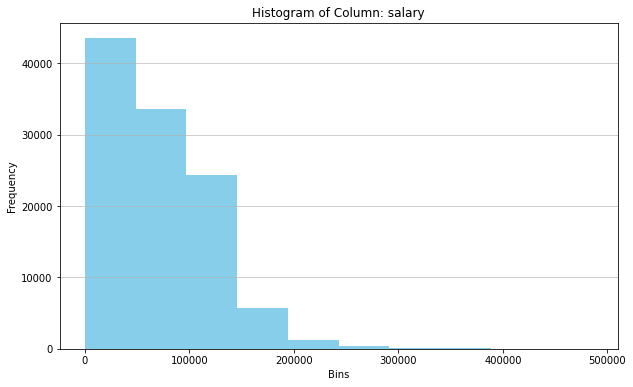

In [0]:
import matplotlib.pyplot as plt
histogram_data = df.select('salary').rdd.flatMap(lambda x: x).histogram(10)

# Prepare data for plotting
bins = histogram_data[0]
frequency = histogram_data[1]

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.bar(bins[:-1], frequency, width=(bins[1]-bins[0]), align='edge', color='skyblue')
plt.xlabel('Bins')
plt.ylabel('Frequency')
plt.title('Histogram of Column: salary')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [0]:
head = english_df1.limit(5)

In [0]:
from sparknlp.annotator import Tokenizer, BertEmbeddings, SentenceEmbeddings
import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.ml import Pipeline
from pyspark.sql import functions as F

text_columns = ["position", "experience_description", "education"]
result = english_df1
for col in text_columns:
    document_assembler = DocumentAssembler() \
                    .setInputCol(col) \
                    .setOutputCol("document")
    sentence = SentenceDetector() \
                    .setInputCols(["document"]) \
                    .setOutputCol("sentence")
    tokenizer = Tokenizer() \
                    .setInputCols(["sentence"]) \
                    .setOutputCol("token")
        
    bert_embeddings = BertEmbeddings().pretrained(name='small_bert_L4_256', lang='en') \
                    .setInputCols(["sentence",'token'])\
                    .setOutputCol(f"{col}_embeddings")
    embeddingsSentence = SentenceEmbeddings() \
                    .setInputCols(["sentence", f"{col}_embeddings"]) \
                    .setOutputCol(f"{col}_embeddings") \
                    .setPoolingStrategy("AVERAGE")
    bert_pipeline = Pipeline(stages=[document_assembler,
                                        sentence,
                                        tokenizer,
                                        bert_embeddings,
                                        embeddingsSentence
                                        ])


    model = bert_pipeline.fit(result)
    result = model.transform(result)
    result = result.drop("document", "sentence", "token")


small_bert_L4_256 download started this may take some time.
Approximate size to download 40.5 MB
[OK!]
small_bert_L4_256 download started this may take some time.
Approximate size to download 40.5 MB
[OK!]
small_bert_L4_256 download started this may take some time.
Approximate size to download 40.5 MB
[OK!]


In [0]:
english_df1.count(), result.count()

Out[13]: (84395, 84395)

In [0]:
result.write.format("parquet").save(f"/result2.parquet")
# result1.write.format("parquet").save(f"/result1.parquet")

In [0]:
result2 = spark.read.parquet("/result2.parquet")

In [0]:

text_columns = ["position", "experience_description", "education"]

In [0]:
result1 = result
result1.count()

Out[17]: 84395

In [0]:
from pyspark.sql import functions as F
for col in text_columns:
    result2 = result2.withColumn(col, F.col(f"{col}_embeddings.embeddings").getItem(0))


In [0]:
for col in text_columns:
    result2 = result2.drop(f"{col}_embeddings")

In [0]:
result_df = result2.withColumn("salary", result2["salary"].cast("float"))
result_df = result_df.withColumn("total_experience_years", result_df["total_experience_years"].cast("float"))
result_df = result_df.withColumn("education_length", result_df["education_length"].cast("float"))
result_df = result_df.withColumn("recommendations_count", result_df["recommendations_count"].cast("float"))
result_df = result_df.withColumn("followers", result_df["followers"].cast("float"))
result_df = result_df.withColumn("number_of_languages", result_df["number_of_languages"].cast("float"))

In [0]:
from pyspark.sql.functions import col, array, concat

# Get the list of column names excluding 'id' and 'salary'
columns_to_merge = [col_name for col_name in result_df.columns if col_name not in ['id', 'salary']]

# Cast non-array columns to arrays of floats
df = result_df.withColumn("total_experience_years", array(col("total_experience_years")))
df = df.withColumn("education_length", array(col("education_length")))
df = df.withColumn("recommendations_count", array(col("recommendations_count")))
df = df.withColumn("followers", array(col("followers")))
df = df.withColumn("number_of_languages", array(col("number_of_languages")))

# Merge the selected columns into one array column
df = df.withColumn("merged_array", array(*[col(col_name) for col_name in columns_to_merge]))


In [0]:
from pyspark.sql.functions import col, array, concat, flatten
df = df.withColumn("merged_array", flatten(col("merged_array")))

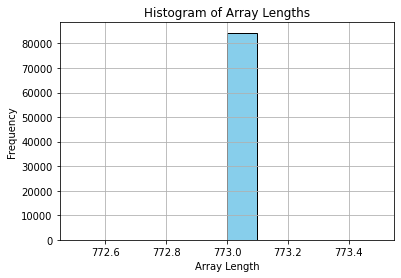

In [0]:
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
import matplotlib.pyplot as plt

def array_length(arr):
    return len(arr)

# Register UDF
array_length_udf = udf(array_length, IntegerType())

# Add a new column with array lengths
df_with_length = df.withColumn("array_length", array_length_udf(df["merged_array"]))

# Convert to Pandas DataFrame for plotting
pandas_df = df_with_length.select("array_length").toPandas()

# Plot histogram
plt.hist(pandas_df["array_length"], bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Array Length')
plt.ylabel('Frequency')
plt.title('Histogram of Array Lengths')
plt.grid(True)
plt.show()

In [0]:
# df.select('id', 'merged_array', 'salary').write.format("parquet").save(f"/df_processed10.parquet")

Train and Eval model

In [0]:
df = spark.read.parquet("/df_processed10.parquet")

In [0]:
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator

# Define a UDF to convert array<float> to vector
array_to_vector_udf = udf(lambda arr: Vectors.dense(arr), VectorUDT())

# Apply the UDF to create a vector column
df = df.withColumn("features", array_to_vector_udf("merged_array"))

# Split the data into training and test sets
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

In [0]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator

# Define a UDF to convert array<float> to vector
array_to_vector_udf = udf(lambda arr: Vectors.dense(arr), VectorUDT())

# Apply the UDF to create a vector column
df = df.withColumn("features", array_to_vector_udf("merged_array"))

# Split the data into training and test sets
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

# Define the RandomForestRegressor
rf = RandomForestRegressor(featuresCol="features", labelCol="salary")

# Train the model
model = rf.fit(train_data)

# Make predictions
predictions = model.transform(test_data)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol="salary", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = {:.2f}".format(rmse))


Root Mean Squared Error (RMSE) on test data = 29710.71


In [0]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
from xgboost.spark import SparkXGBRegressor

xgb = SparkXGBRegressor(
  features_col="features",
  label_col="salary",
  num_workers=2,
)

# Train the model
model = xgb.fit(train_data)

# Make predictions
predictions = model.transform(test_data)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol="salary", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = {:.2f}".format(rmse))



2024-04-15 16:54:10,956 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 2 workers with
	booster params: {'objective': 'reg:squarederror', 'device': 'cpu', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2024-04-15 16:55:19,577 INFO XGBoost-PySpark: _fit Finished xgboost training!
Root Mean Squared Error (RMSE) on test data = 14633.58


In [0]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol="features", labelCol="salary")

# Train the model
model = lr.fit(train_data)

# Make predictions
predictions = model.transform(test_data)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol="salary", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = {:.2f}".format(rmse))

Root Mean Squared Error (RMSE) on test data = 25506.20


As we can see xgboost model got the lower rmse on test data, Therefore we will choose it for inference

In [0]:
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator
from xgboost.spark import SparkXGBRegressor

# Define a UDF to convert array<float> to vector
array_to_vector_udf = udf(lambda arr: Vectors.dense(arr), VectorUDT())

# Apply the UDF to create a vector column
df = df.withColumn("features", array_to_vector_udf("merged_array"))

train_data = df

xgb_model = SparkXGBRegressor(
  features_col="features",
  label_col="salary",
  num_workers=2,
)

# Train the model
model = xgb_model.fit(train_data)



2024-04-15 16:56:11,197 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 2 workers with
	booster params: {'objective': 'reg:squarederror', 'device': 'cpu', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2024-04-15 16:57:25,738 INFO XGBoost-PySpark: _fit Finished xgboost training!


In [0]:
final_xgb_model = model

#Inference

The User will input his features as 

position: string,                   
current salary: float,                     
experience: array of struct, 
education: array of struct, 
languages: array of struct, 
recommendations_count': integer, followers: integer

And he will get an answer about his predicted salary, and suggestions for increasing it.
              
    

Assumptions - the input has non Nan values

In [0]:
from pyspark.sql.functions import lit
profiles_first = spark.read.parquet('/linkedin/people').dropna().limit(1).select('position', 'experience', 'education', 'languages', 'recommendations_count', 'followers')
salary = 17.52
profiles_first = profiles_first.withColumn('salary', lit(salary))
profiles_first.toPandas()

/databricks/spark/python/pyspark/sql/pandas/conversion.py:119: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field experience. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: ArrayType(StructType([StructField('company', StringType(), True), StructField('company_id', StringType(), True), StructField('description', StringType(), True), StructField('duration', StringType(), True), StructField('duration_short', StringType(), True), StructField('end_date', StringType(), True), StructField('location', StringType(), True), StructField('positions', ArrayType(StructType([StructField('description', StringType(), True), StructField('duration', StringType(), True), StructField('duration_short', StringType(), True), StructField('end_date', Strin

,position,experience,education,languages,recommendations_count,followers,salary
0,Assurity Title,"[(None, None, As leaders in the title services...","[(Bachelor of Education - BEd, None, Education...",[],1,2000,17.52


In [0]:
from pyspark.sql.functions import col, struct, array_contains, expr, size
df_extracted = profiles_first.withColumn("experience_description", expr("transform(experience, x -> x.description)")) \
                .withColumn("experience_duration", expr("transform(experience, x -> x.duration)"))

In [0]:
df_ed_split = df_extracted.withColumn("education_degree", expr("transform(education, x -> x.degree)")) \
                .withColumn("education_field", expr("transform(education, x -> x.field)"))\
                .withColumn("education_title", expr("transform(education, x -> x.title)")).drop("experience", "education")

In [0]:
df_with_length = df_ed_split.withColumn("education_length", size("education_degree"))

In [0]:
from pyspark.sql.functions import udf, explode, sum, col
from pyspark.sql.types import FloatType  
import re  
  
# Define the UDF  
def convert_to_years(duration):  
    years = 0  
    months = 0  
  
    # Use regex to find any number of years in the string  
    years_match = re.search(r'(\d+) year', duration)  
    if years_match:  
        years = int(years_match.group(1))  
  
    # Use regex to find any number of months in the string  
    months_match = re.search(r'(\d+) month', duration)  
    if months_match:  
        months = int(months_match.group(1))  
  
    # Convert months to years and add to the year total  
    total_years = years + months/12  
    return total_years  
  
# Convert Python function to PySpark UDF and specify return type  
convert_to_years_udf = udf(convert_to_years, FloatType())  
  
# Flatten the array column  
df = df_with_length.withColumn('experience_duration', explode(df_with_length['experience_duration']))  
  
# Apply UDF to the column  
df = df.withColumn('experience_duration_years', convert_to_years_udf(df['experience_duration'])) 

# Sum all the years for each id  
df = df.groupBy("position").agg(sum("experience_duration_years").alias("total_experience_years"))  

# Join the original dataframe with the aggregated dataframe  
df_processed_final = df_with_length.join(df, on='position', how='left').drop('experience_duration', 'experience_length')  

# Convert 'total_experience_years' to integer  
df_processed_final = df_processed_final.withColumn('total_experience_years', col('total_experience_years').cast('integer')) 

In [0]:
joined_dataset = df_processed_final.withColumn("education", expr("transform(arrays_zip(education_degree, education_field, education_title), x -> concat(x.education_degree, ' in ', x.education_field, ' from ', x.education_title))")).drop('education_degree', 'education_field', 'education_title')

In [0]:
from pyspark.sql.functions import concat_ws, col
df = joined_dataset.withColumn("experience_description", concat_ws(" ", col("experience_description")))
df = df.withColumn("education", concat_ws(" ", col("education"))) 

In [0]:
df = df.withColumn('number_of_languages', size("languages")).drop('languages')

In [0]:
result_df = df.withColumn("salary", df["salary"].cast("float"))
result_df = result_df.withColumn("total_experience_years", result_df["total_experience_years"].cast("float"))
result_df = result_df.withColumn("education_length", result_df["education_length"].cast("float"))
result_df = result_df.withColumn("recommendations_count", result_df["recommendations_count"].cast("float"))
result_df = result_df.withColumn("followers", result_df["followers"].cast("float"))
result_df = result_df.withColumn("number_of_languages", result_df["number_of_languages"].cast("float"))

In [0]:
exp_years = result_df.select('total_experience_years').collect()[0].total_experience_years
ed_length = result_df.select('education_length').collect()[0].education_length

In [0]:
# Original DataFrame
original_df = result_df


# Define the changes you want to make to the desired column
changes = [exp_years+2, exp_years+4, exp_years+6, exp_years+8]  

# List to store modified DataFrames
modified_dfs = []

# Create a new DataFrame for each change
for change in changes:
    # Create a new DataFrame with the desired column modified
    modified_df = original_df.withColumn("total_experience_years", lit(change))
    modified_dfs.append(modified_df)

# Concatenate all modified DataFrames
duplicated_df = original_df
for modified_df in modified_dfs:
    duplicated_df = duplicated_df.union(modified_df)

# Show the DataFrame with duplicated rows
duplicated_df.select('position', 'total_experience_years').show()

+--------------+----------------------+
|      position|total_experience_years|
+--------------+----------------------+
|Assurity Title|                  25.0|
|Assurity Title|                  27.0|
|Assurity Title|                  29.0|
|Assurity Title|                  31.0|
|Assurity Title|                  33.0|
+--------------+----------------------+



In [0]:
# Original DataFrame
original_df = duplicated_df


# Define the changes you want to make to the desired column
changes = [ed_length+1, ed_length+2, ed_length+3]  

# List to store modified DataFrames
modified_dfs = []

# Create a new DataFrame for each change
for change in changes:
    # Create a new DataFrame with the desired column modified
    modified_df = original_df.withColumn("education_length", lit(change))
    modified_dfs.append(modified_df)

# Concatenate all modified DataFrames
duplicated_df = original_df
for modified_df in modified_dfs:
    duplicated_df = duplicated_df.union(modified_df)

# Show the DataFrame with duplicated rows
duplicated_df.select('position', 'education_length', 'total_experience_years').show()

+--------------+----------------+----------------------+
|      position|education_length|total_experience_years|
+--------------+----------------+----------------------+
|Assurity Title|             2.0|                  25.0|
|Assurity Title|             2.0|                  27.0|
|Assurity Title|             2.0|                  29.0|
|Assurity Title|             2.0|                  31.0|
|Assurity Title|             2.0|                  33.0|
|Assurity Title|             3.0|                  25.0|
|Assurity Title|             3.0|                  27.0|
|Assurity Title|             3.0|                  29.0|
|Assurity Title|             3.0|                  31.0|
|Assurity Title|             3.0|                  33.0|
|Assurity Title|             4.0|                  25.0|
|Assurity Title|             4.0|                  27.0|
|Assurity Title|             4.0|                  29.0|
|Assurity Title|             4.0|                  31.0|
|Assurity Title|             4.

In [0]:
from sparknlp.annotator import Tokenizer, BertEmbeddings, SentenceEmbeddings
import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.ml import Pipeline
from pyspark.sql import functions as F

text_columns = ["position", "experience_description", "education"]
result = duplicated_df
for col in text_columns:
    document_assembler = DocumentAssembler() \
                    .setInputCol(col) \
                    .setOutputCol("document")
    sentence = SentenceDetector() \
                    .setInputCols(["document"]) \
                    .setOutputCol("sentence")
    tokenizer = Tokenizer() \
                    .setInputCols(["sentence"]) \
                    .setOutputCol("token")
        
    bert_embeddings = BertEmbeddings().pretrained(name='small_bert_L4_256', lang='en') \
                    .setInputCols(["sentence",'token'])\
                    .setOutputCol(f"{col}_embeddings")
    embeddingsSentence = SentenceEmbeddings() \
                    .setInputCols(["sentence", f"{col}_embeddings"]) \
                    .setOutputCol(f"{col}_embeddings") \
                    .setPoolingStrategy("AVERAGE")
    bert_pipeline = Pipeline(stages=[document_assembler,
                                        sentence,
                                        tokenizer,
                                        bert_embeddings,
                                        embeddingsSentence
                                        ])


    model = bert_pipeline.fit(result)
    result = model.transform(result)
    result = result.drop("document", "sentence", "token")


small_bert_L4_256 download started this may take some time.
Approximate size to download 40.5 MB
[OK!]
small_bert_L4_256 download started this may take some time.
Approximate size to download 40.5 MB
[OK!]
small_bert_L4_256 download started this may take some time.
Approximate size to download 40.5 MB
[OK!]


In [0]:
from pyspark.sql import functions as F
for col in text_columns:
    result = result.withColumn(col, F.col(f"{col}_embeddings.embeddings").getItem(0))

In [0]:
for col in text_columns:
    result = result.drop(f"{col}_embeddings")

In [0]:
from pyspark.sql.functions import col, array, concat

# Get the list of column names excluding 'id' and 'salary'
columns_to_merge = [col_name for col_name in result.columns if col_name not in ['id', 'salary']]

# Cast non-array columns to arrays of floats
df = result.withColumn("total_experience_years", array(col("total_experience_years")))
df = df.withColumn("education_length", array(col("education_length")))
df = df.withColumn("recommendations_count", array(col("recommendations_count")))
df = df.withColumn("followers", array(col("followers")))
df = df.withColumn("number_of_languages", array(col("number_of_languages")))

# Merge the selected columns into one array column
df = df.withColumn("merged_array", array(*[col(col_name) for col_name in columns_to_merge]))

In [0]:
from pyspark.sql.functions import col, array, concat, flatten
df = df.withColumn("merged_array", flatten(col("merged_array")))

In [0]:
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator

# Define a UDF to convert array<float> to vector
array_to_vector_udf = udf(lambda arr: Vectors.dense(arr), VectorUDT())

# Apply the UDF to create a vector column
df = df.withColumn("features", array_to_vector_udf("merged_array"))


In [0]:
# Make predictions
predictions = final_xgb_model.transform(df)

In [0]:
display(predictions.select('salary', 'total_experience_years', 'education_length'))

salary,total_experience_years,education_length
17.52,List(25.0),List(2.0)
17.52,List(27.0),List(2.0)
17.52,List(29.0),List(2.0)
17.52,List(31.0),List(2.0)
17.52,List(33.0),List(2.0)
17.52,List(25.0),List(3.0)
17.52,List(27.0),List(3.0)
17.52,List(29.0),List(3.0)
17.52,List(31.0),List(3.0)
17.52,List(33.0),List(3.0)


In [0]:
display(result_df)

position,recommendations_count,followers,salary,experience_description,education_length,total_experience_years,education,number_of_languages
Assurity Title,1.0,2000.0,17.52,"As leaders in the title services industry, we’ve built the experience and relationships that set us apart from other title companies. Our client list is as vibrant and diverse as the cities we service in Florida. Whether you are a realtor, lender, or consumer, we help you with our full-spectrum title service and negotiation processes. Our agency offers a broad spectrum of title services that span Tampa, as well as the state of Florida. When you work with Assurity Title, you will experience the difference we make in easing your mind before closing on a new investment. Whether you need title searches or insurance and legal document preparation, we can help you with your next real estate transaction. We provide the following title services: Residential and commercial closings Escrow services FSBO Title searches Title insurance Legal document preparation Whether you are ready to start the process of title services and closing or only have a question, our experts are always available to help. At Assurity Title LLC, you never have to worry about unpleasant surprises when you are looking into a real estate transaction. We strive to provide a superior closing experience for all applicable parties. Our transparent and thorough title services ensure that no underlying issues exist with the property. If any complications do come up, we take action to resolve problems quickly and efficiently. Our title company’s ultimate goal is to protect both buyers and sellers with urgency, integrity, and care. If you’re ready to schedule an appointment, get a quote, or request more information! Contact us now at (813) 556-7501. Show less",2.0,25.0,Bachelor of Education - BEd in Education from University of South Florida,0.0
